# Translation using different NLP packages

### Content

- [1. Standard Imports](#1.-Standard-Imports)
- [2. Importing dataset](#2.-Importing-dataset)
- [3. Processing 'reviews' column](#3.-Processing-reviews)
- [4. nltk.corpus to check english language](#4.-nltk.corpus-to-check-english-language)
- [5. Splitting of dataframes into english and non-english reviews](#5.-Splitting-of-dataframes-into-english-and-non-english-reviews)
- [6. Spacy to detect different languages](#6.-Spacy-to-detect-different-languages)
- [7. google translator package to translate reviews](#7.-google-translator-package-to-translate-reviews)
- [8. Saving part of the translated Reviews](#8.-Saving-part-of-the-translated-Reviews)
- [9. translating the remaining text in Russian to English](#9.-translating-the-remaining-text-in-Russian-to-English)
- [10. Merging translated reviews into 1 DataFrame](#10.-Merging-translated-reviews-into-1-DataFrame)
- [11. Exporting out translated dataframe](#11.-Exporting-out-translated-dataframe)
- [12. Saving backups](#12.-Saving-backups)     
- [13. translating the remaining text in Spanish to English](#13.-translating-the-remaining-text-in-Spanish-to-English)
- [14. Translating in batches](#14.-Translating-in-batches)
- [15. Exporting translated dataframe](#15.-Exporting-translated-dataframe)

### 1. Standard Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports for preprocessing text
import regex as re
from bs4 import BeautifulSoup   
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# different nlp library
from textblob import TextBlob
from langdetect import detect
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# for translation
import google_trans_new
from google_trans_new import google_translator

### 2. Importing dataset

In [84]:
df_cleaned = courses = pd.read_csv('df_cleaned.csv')
df_cleaned.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1.0,34,University,11,2015,Nov-2015,2015-11


In [85]:
# checking that all reviews are present
df_cleaned['reviews'].isnull().sum()

0

In [86]:
# shape of dataframe, there are 438726 rows and 14 columns
df_cleaned.shape

(438726, 14)

### 3. Processing reviews

- rows in `reviews` are preprocessed and split into words so that they can be checked against the NLP libraries

In [98]:
# removing all the digits and symbols
# lowercase words
# these processed text will be checked against words from nltk.corpus

def review_to_splitwords(raw_review):
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',raw_review)
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return(" ".join(words))  

In [99]:
# applying function to process text
df_cleaned['reviews split'] = df_cleaned['reviews'].apply(review_to_splitwords)

### 4. nltk.corpus to check english language

- **nltk.corpus** is checked against the words in `reviews` to identify if they are english 'en' or not

In [100]:
#from nltk.corpus import words
# this will be the dictionary the reviews will check against and determine if the text is english
nltk_list = words.words()

# function to return 'en' if text is english
def is_english(row):
    for i in nltk_list:
        if i in row:
            return 'en'

In [101]:
# applying function to reviews split and inputting 'en' in new column
df_cleaned['language'] = df_cleaned['reviews split'].apply(is_english)

### 5. Splitting of dataframes into english and non-english reviews

 - upon checking against the **nltk.corpus**, there are many `reviews` that are not in english
 - `reviews` not in english are separated and will be translated

In [103]:
# checking reviews that are english where ['language'] == 'en'

english_reviews = df_cleaned[df_cleaned['language'] == 'en']
english_reviews.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03,this is an extremely basic course machine lear...,en
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1.0,34,University,11,2015,Nov-2015,2015-11,the course is ok but the certification procedu...,en


In [104]:
# these rows of reviews will need translation, where ['language'] != 'en'

needs_translation = df_cleaned[df_cleaned['language'] != 'en']
needs_translation.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
17,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,В\n требованиях к прохождению курса необходимо...,By Ястрембский А Н,2020-10-01,1.0,72,University,10,2020,Oct-2020,2020-10,,None
639,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Хорошее введение в машинное обучение. В начале...,By Расов А М,2018-05-26,4.0,56,University,5,2018,May-2018,2018-05,,None


In [105]:
# these rows are not english and there are a mixture of languages
df_cleaned[df_cleaned['language'] != 'en'][['reviews', 'language']]

,reviews,language
17,В\n требованиях к прохождению курса необходимо...,None
639,Хорошее введение в машинное обучение. В начале...,None
2494,挺好的 理论讲的很清晰 整体难度适中,None
8658,"Очень полезный и интересный курс, особенно, ес...",None
10086,Очень понятный и интересный курс. Преподавател...,None
...,...,...
437561,Самое то для новичка,None
437562,Все было очень круто,None
437563,Все ясно и понятно!,None
437564,"Все круто, значит 5",None


### 6. Spacy to detect different languages

 - **Spacy** library was used to detect the different languages of the non-english `reviews`.
 - upon checking against **Spacy**, there are russian 'ru', arabic 'ar', korean 'ko' `reviews`... etc.
 - This aligns with how MOOC (Massive Open Online Courses) are accessible for anyone with internet connection to enroll.

In [95]:
#import spacy
#from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")

def get_lang_detector(nlp, name):
    return LanguageDetector()

#nlp = spacy.load("en_core_web_sm")
#Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
#text = 'Check is this English?'
#doc = nlp(text)
#print(doc._.language)

# checking usage of spacy_langdetect
text = 'is this english'
nlp(text)._.language['language']

'en'

In [125]:
# took a snippet of the first non-english text for testing
nlp('Все было очень круто')._.language['language']

'ru'

In [126]:
# creating a function to detect language through ['reviews'] columns
def what_language(row):
    return nlp(row)._.language['language']

In [127]:
# detecting language 
needs_translation = needs_translation.copy()
needs_translation['language'] = needs_translation['reviews'].apply(what_language)

In [116]:
# different languages based on Spacy_langdetect
needs_translation['language'].value_counts()

ru         1566
ar          108
ko           84
uk           19
zh-cn        13
th            7
bg            7
UNKNOWN       6
mk            4
he            3
el            2
ja            1
hi            1
fa            1
ml            1
Name: language, dtype: int64

In [132]:
pd.DataFrame(needs_translation['language'].value_counts()).head()

,language
ru,1568
ar,108
ko,83
uk,19
zh-cn,14


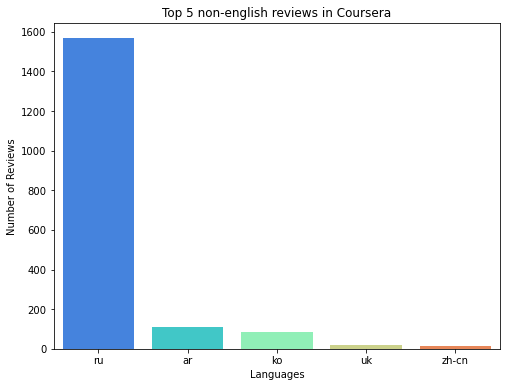

In [139]:
temp_table = pd.DataFrame(needs_translation['language'].value_counts()).head()
plt.figure(figsize=(8,6))
sns.barplot(data=temp_table, x=temp_table.index, y='language', palette='rainbow')
plt.ylabel('Number of Reviews')
plt.xlabel('Languages')
plt.title('Top 5 non-english reviews in Coursera');

In [121]:
# 'UNKNOWN' are symbols hence not detected as english or other language
# hence these reviews are not significant

needs_translation = needs_translation[needs_translation['language'] !='UNKNOWN']

In [129]:
# there are a total of 1817 reviews that require translation
len(needs_translation)

1817

### 7. google translator package to translate reviews

- **google_trans_new** is a free python for google translate.
- however, there are API limits and the `reviews` translated in batches by slicing the dataframe by 500 rows.
- tried submitting all the non-english `reviews` in 1 time and use blocked due to 423 error.
- in addition, the requests have to be submitted in a few minutes interval.
- therefore, this translation using google_trans_new was done over 4 days.

In [26]:
#import google_trans_new
#from google_trans_new import google_translator

# instantiating the goole_translator function
translator = google_translator()  

# function to translate words based on goole_translator function
def translate_word(row):
    return translator.translate(row,lang_tgt='en') 

In [62]:
# splitting the Dataframe as google_trans_new has an API limit
other_needs_translation = needs_translation[needs_translation['language']!='ru']
other_needs_translation = other_needs_translation.copy()

# applying the translation to other languages except for russian
other_needs_translation['reviews'] = other_needs_translation['reviews'].apply(translate_word)

In [145]:
# before translation
display(needs_translation[needs_translation['language']!='ru'].head(2))

# before translation review column
needs_translation[needs_translation['language']!='ru']['reviews'].head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
2494,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,挺好的 理论讲的很清晰 整体难度适中,By zhang x,2019-02-12,4.0,6,University,2,2019,Feb-2019,2019-02,,zh-cn
10736,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,「機械学習」とはどんなものか？内部構造やアルゴリズムの理論はどうなってるのか？という漠然とし...,By Keiichiro N,2018-09-06,5.0,5,University,9,2018,Sep-2018,2018-09,,ja


2494                                 挺好的   理论讲的很清晰 整体难度适中 
10736    「機械学習」とはどんなものか？内部構造やアルゴリズムの理論はどうなってるのか？という漠然とし...
Name: reviews, dtype: object

In [146]:
# after translation
display(other_needs_translation.head(2))

# after translation - review columns
other_needs_translation['reviews'].head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
2494,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"Very good theory, very clear and overall, diff...",By zhang x,2019-02-12,4.0,6,University,2,2019,Feb-2019,2019-02,,zh-cn
10736,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"What is ""Machine Learning""? What is the theory...",By Keiichiro N,2018-09-06,5.0,5,University,9,2018,Sep-2018,2018-09,,ja


2494     Very good theory, very clear and overall, diff...
10736    What is "Machine Learning"? What is the theory...
Name: reviews, dtype: object

### 8. Saving part of the translated Reviews

In [151]:
english_reviews.head(1)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03,this is an extremely basic course machine lear...,en


In [152]:
other_needs_translation.tail(1)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
437564,Математика и Python для анализа данных,Moscow Institute of Physics and Technology,https://www.coursera.org/learn/mathematics-and...,mathematics-and-python,"Everything is cool, it means 5",By Чикин Н Д,2018-01-20,5.0,4,Business est,1,2018,Jan-2018,2018-01,,mk


In [147]:
translated_reviews_part1 = pd.concat([english_reviews, other_needs_translation])
translated_reviews_part1.to_csv('translated_reviews_part1.csv', index=False)

translated_reviews_part1 = pd.read_csv('translated_reviews_part1.csv')
translated_reviews_part1.head(1)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03,this is an extremely basic course machine lear...,en


In [148]:
translated_reviews_part1.shape

(437161, 16)

### 9. translating the remaining text in Russian to English

- There are many `reviews` in Russian, hence they are grouped together and sliced into 300 rows each time.
- each slice is then translated in google_trans_new and then merged together with english `reviews`.

In [149]:
ru_needs_translation_full = needs_translation[needs_translation['language']=='ru']
ru_needs_translation_full = ru_needs_translation_full.copy()

In [150]:
ru_needs_translation_full.shape

(1568, 16)

In [153]:
# saving as backup
ru_needs_translation_full.to_csv('ru_needs_translation_full.csv', index=False)
pd.read_csv('ru_needs_translation_full.csv').head(1)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,В\n требованиях к прохождению курса необходимо...,By Ястрембский А Н,2020-10-01,1.0,72,University,10,2020,Oct-2020,2020-10,NaN,ru


In [1]:
#import google_trans_new
#from google_trans_new import google_translator

# instantiating the goole_translator function
translator = google_translator()  

# function to translate words based on goole_translator function
def translate_word(row):
    return translator.translate(row,lang_tgt='en') 

In [2]:
import pandas as pd

ru_needs_translation_full = pd.read_csv('ru_needs_translation_full.csv')

In [3]:
ru_needs_translation_1 = ru_needs_translation_full[0:300]
ru_needs_translation_2 = ru_needs_translation_full[300:600]
ru_needs_translation_3 = ru_needs_translation_full[600:900]
ru_needs_translation_4 = ru_needs_translation_full[900:1200]
ru_needs_translation_5 = ru_needs_translation_full[1200:]

In [ ]:
ru_needs_translation_1['reviews'] = ru_needs_translation_1['reviews'].apply(translate_word)

In [9]:
ru_needs_translation_2['reviews'] = ru_needs_translation_2['reviews'].apply(translate_word)

In [ ]:
ru_needs_translation_3['reviews'] = ru_needs_translation_3['reviews'].apply(translate_word)

In [ ]:
ru_needs_translation_4['reviews'] = ru_needs_translation_4['reviews'].apply(translate_word)

In [19]:
ru_needs_translation_5['reviews'] = ru_needs_translation_5['reviews'].apply(translate_word)

In [6]:
# checking that translation is complete
ru_needs_translation_1.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,AT Course requirements must be indicated by t...,By Ястрембский А Н,2020-10-01,1.0,72,University,10,2020,Oct-2020,2020-10,NaN,ru
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Good introduction to machine learning. At the ...,By Расов А М,2018-05-26,4.0,56,University,5,2018,May-2018,2018-05,NaN,ru


In [12]:
# checking that translation is complete
ru_needs_translation_2.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
300,Learn to Speak Korean 1,Yonsei University,https://www.coursera.org/learn/learn-speak-kor...,learn-speak-korean1,Thank you very much for such a stunningly simp...,By Ошорова В В,2020-05-10,5.0,12,University,5,2020,May-2020,2020-05,NaN,ru
301,Learn to Speak Korean 1,Yonsei University,https://www.coursera.org/learn/learn-speak-kor...,learn-speak-korean1,Very affordable explanations for foreigners. T...,By Эрмека К,2020-04-25,5.0,9,University,4,2020,Apr-2020,2020-04,NaN,ru


In [16]:
# checking that translation is complete
ru_needs_translation_3.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
600,Основы программирования на Python,National Research University Higher School of ...,https://www.coursera.org/learn/python-osnovy-p...,python-osnovy-programmirovaniya,There were really interesting tasks. And by th...,By Гуслянников С В,2020-08-15,4.0,15,University,8,2020,Aug-2020,2020-08,NaN,ru
601,Основы программирования на Python,National Research University Higher School of ...,https://www.coursera.org/learn/python-osnovy-p...,python-osnovy-programmirovaniya,"An excellent course, only the OOP is better to...",By Никонорова Е А,2019-03-12,4.0,13,University,3,2019,Mar-2019,2019-03,NaN,ru


In [22]:
# checking that translation is complete
ru_needs_translation_4.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
900,Основы разработки на C++: белый пояс,Moscow Institute of Physics and Technology,https://www.coursera.org/learn/c-plus-plus-white,c-plus-plus-white,A good course allows you to learn most of the ...,By Волков П Е,2019-10-22,5.0,38,Business est,10,2019,Oct-2019,2019-10,NaN,ru
901,Основы разработки на C++: белый пояс,Moscow Institute of Physics and Technology,https://www.coursera.org/learn/c-plus-plus-white,c-plus-plus-white,"The course is good, helps to improve the skill...",By Хабибуллин С М,2019-07-07,5.0,22,Business est,7,2019,Jul-2019,2019-07,NaN,ru


In [27]:
# checking that translation is complete
ru_needs_translation_5.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
1200,Математика и Python для анализа данных,Moscow Institute of Physics and Technology,https://www.coursera.org/learn/mathematics-and...,mathematics-and-python,Everything is very successful in this course f...,By Siarhey T,2016-03-22,5.0,30,Business est,3,2016,Mar-2016,2016-03,NaN,ru
1201,Математика и Python для анализа данных,Moscow Institute of Physics and Technology,https://www.coursera.org/learn/mathematics-and...,mathematics-and-python,"The course is definitely good, but unfortunate...",By Anatoly C,2016-03-07,5.0,109,Business est,3,2016,Mar-2016,2016-03,NaN,ru


In [30]:
# concatenate all of the russian translation together
translated_ru_review = pd.concat([ru_needs_translation_1, ru_needs_translation_2, ru_needs_translation_3,
                                  ru_needs_translation_4, ru_needs_translation_5])

translated_ru_review.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,AT Course requirements must be indicated by t...,By Ястрембский А Н,2020-10-01,1.0,72,University,10,2020,Oct-2020,2020-10,NaN,ru
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Good introduction to machine learning. At the ...,By Расов А М,2018-05-26,4.0,56,University,5,2018,May-2018,2018-05,NaN,ru


### 10. Merging translated reviews into 1 DataFrame

In [31]:
# reading in the earlier translated dataframe
translated_reviews_part1 = pd.read_csv('translated_reviews_part1.csv')

In [34]:
# concatenate the earlier translated dataframe with translated russian reviews
translated_reviews = pd.concat([translated_reviews_part1, translated_ru_review])
translated_reviews.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,reviews split,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03,this is an extremely basic course machine lear...,en
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1.0,34,University,11,2015,Nov-2015,2015-11,the course is ok but the certification procedu...,en


In [35]:
# checking for null values in the compiled reviews
translated_reviews.isnull().sum()

name                 0
institution          0
course_url           0
course_id            0
reviews              0
reviewers            0
date_reviews         0
rating               0
count of words       0
University           0
month                0
year                 0
mth-year             0
year-month           0
reviews split     1826
language             0
dtype: int64

In [37]:
# dropping the 'review split' column which is used to check whether language is english or not
translated_df = translated_reviews.drop('reviews split', axis=1)

### 11. Saving the partially translated dataframe

In [38]:
# saving the partially translated dataframe, as there are more translation discovered
translated_df.to_csv('translated_df.csv', index=False)
pd.read_csv('translated_df.csv').head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,3,2017,Mar-2017,2017-03,en
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1.0,34,University,11,2015,Nov-2015,2015-11,en
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1.0,93,University,4,2019,Apr-2019,2019-04,en
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1.0,108,University,9,2015,Sep-2015,2015-09,en
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1.0,81,University,12,2015,Dec-2015,2015-12,en


### 12. Saving backups

In [43]:
# saving the previous translated text as backups
ru_needs_translation_1.to_csv('ru_needs_translation_1.csv', index=False)
ru_needs_translation_2.to_csv('ru_needs_translation_2.csv', index=False)
ru_needs_translation_3.to_csv('ru_needs_translation_3.csv', index=False)
ru_needs_translation_4.to_csv('ru_needs_translation_4.csv', index=False)
ru_needs_translation_5.to_csv('ru_needs_translation_5.csv', index=False)
translated_ru_review.to_csv('translated_ru_review.csv', index=False)

### 13. translating the remaining text in Spanish to English

- on conducting EDA, there were many `reviews` in Spanish that was not detected by **nltk.corpus**
- this could be due to english words are similar to spanish words too
- these `reviews` were identified and translated using **google_trans_new**
- again these `reviews` were sliced into 500 rows at each time and submitted to **google_trans_new** API

In [46]:
# spanish words were identified using 'curso' the most common spanish word found during 
count = 0
for row in translated_df['reviews']:
    if 'curso' in row:
        count += 1

count

24465

In [227]:
translated_df.shape

(438729, 15)

In [228]:
without_spn_df = translated_df.drop(translated_df[translated_df['reviews'].str.contains('curso')].index, axis=0)
without_spn_df.shape

(414245, 15)

In [52]:
spanish_df = translated_df[translated_df['reviews'].str.contains('curso')]

### 14. Translating in batches

In [53]:
spanish_df_1 = spanish_df[1500:2000]

In [54]:
spanish_df_1['reviews'] = spanish_df_1['reviews'].apply(translate_word)

<ipython-input-54-0ac4d05953b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spanish_df_1['reviews'] = spanish_df_1['reviews'].apply(translate_word)


In [56]:
# checking
spanish_df_1.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language
90865,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"This course is really very practical, the way ...",By Luisa F P G,2020-05-11,5.0,69,University,5,2020,May-2020,2020-05,en
90878,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"Very happy for the content of the course, I pr...",By Liliana B,2020-06-19,5.0,60,University,6,2020,Jun-2020,2020-06,en


In [57]:
spanish_df_2 = spanish_df[0:500]
spanish_df_3 = spanish_df[500:1000]
spanish_df_4 = spanish_df[1000:1500]

In [59]:
spanish_df_2 = spanish_df_2.copy()
spanish_df_2['reviews'] = spanish_df_2['reviews'].apply(translate_word)

In [60]:
spanish_df_3 = spanish_df_3.copy()
spanish_df_3['reviews'] = spanish_df_3['reviews'].apply(translate_word)

In [61]:
spanish_df_4 = spanish_df_4.copy()
spanish_df_4['reviews'] = spanish_df_4['reviews'].apply(translate_word)

In [62]:
spanish_df_5 = spanish_df[2000:2500]
spanish_df_6 = spanish_df[2500:3000]
spanish_df_7 = spanish_df[3000:3500]

In [64]:
spanish_df_5 = spanish_df_5.copy()
spanish_df_5['reviews'] = spanish_df_5['reviews'].apply(translate_word)

In [66]:
spanish_df_6 = spanish_df_6.copy()
spanish_df_6['reviews'] = spanish_df_6['reviews'].apply(translate_word)

In [67]:
spanish_df_7 = spanish_df_7.copy()
spanish_df_7['reviews'] = spanish_df_7['reviews'].apply(translate_word)

In [72]:
spanish_df_8 = spanish_df[3500:4000]
spanish_df_9 = spanish_df[4000:4500]
spanish_df_10 = spanish_df[4500:5000]

In [77]:
spanish_df_8 = spanish_df_8.copy()
spanish_df_8['reviews'] = spanish_df_8['reviews'].apply(translate_word)

In [81]:
spanish_df_9 = spanish_df_9.copy()
spanish_df_9['reviews'] = spanish_df_9['reviews'].apply(translate_word)

In [84]:
spanish_df_10 = spanish_df_10.copy()
spanish_df_10['reviews'] = spanish_df_10['reviews'].apply(translate_word)

In [90]:
spanish_df_11 = spanish_df[5000:5500]
spanish_df_12 = spanish_df[5500:6000]
spanish_df_13 = spanish_df[6000:6500]

In [91]:
spanish_df_11 = spanish_df_11.copy()
spanish_df_11['reviews'] = spanish_df_11['reviews'].apply(translate_word)

In [94]:
spanish_df_12 = spanish_df_12.copy()
spanish_df_12['reviews'] = spanish_df_12['reviews'].apply(translate_word)

In [97]:
spanish_df_13 = spanish_df_13.copy()
spanish_df_13['reviews'] = spanish_df_13['reviews'].apply(translate_word)

In [103]:
spanish_df_14 = spanish_df[6500:7000]
spanish_df_15 = spanish_df[7000:7500]
spanish_df_16 = spanish_df[7500:8000]

In [106]:
spanish_df_14 = spanish_df_14.copy()
spanish_df_14['reviews'] = spanish_df_14['reviews'].apply(translate_word)

In [109]:
spanish_df_15 = spanish_df_15.copy()
spanish_df_15['reviews'] = spanish_df_15['reviews'].apply(translate_word)

In [112]:
spanish_df_16 = spanish_df_16.copy()
spanish_df_16['reviews'] = spanish_df_16['reviews'].apply(translate_word)

In [115]:
spanish_df_17 = spanish_df[8000:8500]
spanish_df_18 = spanish_df[8500:9000]
spanish_df_19 = spanish_df[9000:9500]

In [116]:
spanish_df_17 = spanish_df_17.copy()
spanish_df_17['reviews'] = spanish_df_17['reviews'].apply(translate_word)

In [119]:
spanish_df_18 = spanish_df_18.copy()
spanish_df_18['reviews'] = spanish_df_18['reviews'].apply(translate_word)

In [122]:
spanish_df_19 = spanish_df_19.copy()
spanish_df_19['reviews'] = spanish_df_19['reviews'].apply(translate_word)

In [125]:
spanish_df_20 = spanish_df[9500:10000]
spanish_df_20['reviews'] = spanish_df_20['reviews'].apply(translate_word)

In [128]:
translated_spanish_part1 = pd.concat([spanish_df_1, spanish_df_2, spanish_df_3, spanish_df_4, spanish_df_5,
                                      spanish_df_6, spanish_df_7, spanish_df_8, spanish_df_9, spanish_df_10,
                                     spanish_df_11,spanish_df_12, spanish_df_13, spanish_df_14, spanish_df_15,
                                     spanish_df_16, spanish_df_17, spanish_df_18, spanish_df_19, spanish_df_20])

In [130]:
translated_spanish_part1.to_csv('translated_spanish_part1.csv', index=False)

In [131]:
translated_spanish_part1.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language
90865,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"This course is really very practical, the way ...",By Luisa F P G,2020-05-11,5.0,69,University,5,2020,May-2020,2020-05,en
90878,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"Very happy for the content of the course, I pr...",By Liliana B,2020-06-19,5.0,60,University,6,2020,Jun-2020,2020-06,en


In [132]:
translated_spanish_part1.shape

(10000, 15)

In [133]:
spanish_df_half = spanish_df[10000:]

In [134]:
spanish_df_half.shape

(14465, 15)

In [135]:
spanish_df_21 = spanish_df_half[0:500]
spanish_df_22 = spanish_df_half[500:1000]
spanish_df_23 = spanish_df_half[1000:1500]
spanish_df_24 = spanish_df_half[1500:2000]
spanish_df_25 = spanish_df_half[2500:3000]

In [136]:
spanish_df_21.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language
282471,Nutrición y obesidad: control de sobrepeso,Universidad Nacional Autónoma de México,https://www.coursera.org/learn/nutricion-obesi...,nutricion-obesidad-sobrepeso,fue fasinante el viaje por curso de nutricion ...,By CCANAHUIRE C r,2020-06-18,5.0,18,Business est,6,2020,Jun-2020,2020-06,en
282472,Nutrición y obesidad: control de sobrepeso,Universidad Nacional Autónoma de México,https://www.coursera.org/learn/nutricion-obesi...,nutricion-obesidad-sobrepeso,"La verdad lo recomiendo, es un curso en donde ...",By María d l A S v,2020-06-18,5.0,20,Business est,6,2020,Jun-2020,2020-06,en


In [137]:
spanish_df_21 = spanish_df_21.copy()
spanish_df_21['reviews'] = spanish_df_21['reviews'].apply(translate_word)

In [139]:
spanish_df_22 = spanish_df_22.copy()
spanish_df_22['reviews'] = spanish_df_22['reviews'].apply(translate_word)

In [142]:
spanish_df_23 = spanish_df_23.copy()
spanish_df_23['reviews'] = spanish_df_23['reviews'].apply(translate_word)

In [147]:
spanish_df_24 = spanish_df_24.copy()
spanish_df_24['reviews'] = spanish_df_24['reviews'].apply(translate_word)

In [152]:
spanish_df_25 = spanish_df_25.copy()
spanish_df_25['reviews'] = spanish_df_25['reviews'].apply(translate_word)

In [154]:
spanish_df_30 = spanish_df_half[2000:2500]
spanish_df_26 = spanish_df_half[3000:3500]
spanish_df_27 = spanish_df_half[3500:4000]
spanish_df_28 = spanish_df_half[4000:4500]
spanish_df_29 = spanish_df_half[4500:5000]

In [155]:
spanish_df_30 = spanish_df_30.copy()
spanish_df_30['reviews'] = spanish_df_30['reviews'].apply(translate_word)

In [157]:
spanish_df_26 = spanish_df_26.copy()
spanish_df_26['reviews'] = spanish_df_26['reviews'].apply(translate_word)

In [161]:
spanish_df_27 = spanish_df_27.copy()
spanish_df_27['reviews'] = spanish_df_27['reviews'].apply(translate_word)

In [162]:
spanish_df_28 = spanish_df_28.copy()
spanish_df_28['reviews'] = spanish_df_28['reviews'].apply(translate_word)

In [165]:
spanish_df_29 = spanish_df_29.copy()
spanish_df_29['reviews'] = spanish_df_29['reviews'].apply(translate_word)

In [168]:
spanish_df_31 = spanish_df_half[5000:5500]
spanish_df_32 = spanish_df_half[5500:6000]
spanish_df_33 = spanish_df_half[6000:6500]
spanish_df_34 = spanish_df_half[6500:7000]
spanish_df_35 = spanish_df_half[7000:7500]

In [169]:
spanish_df_31 = spanish_df_31.copy()
spanish_df_31['reviews'] = spanish_df_31['reviews'].apply(translate_word)

In [172]:
spanish_df_32 = spanish_df_32.copy()
spanish_df_32['reviews'] = spanish_df_32['reviews'].apply(translate_word)

In [176]:
spanish_df_33 = spanish_df_33.copy()
spanish_df_33['reviews'] = spanish_df_33['reviews'].apply(translate_word)

In [179]:
spanish_df_34 = spanish_df_34.copy()
spanish_df_34['reviews'] = spanish_df_34['reviews'].apply(translate_word)

In [182]:
spanish_df_35 = spanish_df_35.copy()
spanish_df_35['reviews'] = spanish_df_35['reviews'].apply(translate_word)

In [186]:
spanish_df_36 = spanish_df_half[7500:8000]
spanish_df_37 = spanish_df_half[8000:8500]
spanish_df_38 = spanish_df_half[8500:9000]
spanish_df_39 = spanish_df_half[9000:9500]
spanish_df_40 = spanish_df_half[9500:10000]

In [187]:
spanish_df_36 = spanish_df_36.copy()
spanish_df_36['reviews'] = spanish_df_36['reviews'].apply(translate_word)

In [188]:
spanish_df_37 = spanish_df_37.copy()
spanish_df_37['reviews'] = spanish_df_37['reviews'].apply(translate_word)

In [189]:
spanish_df_38 = spanish_df_38.copy()
spanish_df_38['reviews'] = spanish_df_38['reviews'].apply(translate_word)

In [192]:
spanish_df_39 = spanish_df_39.copy()
spanish_df_39['reviews'] = spanish_df_39['reviews'].apply(translate_word)

In [193]:
spanish_df_40 = spanish_df_40.copy()
spanish_df_40['reviews'] = spanish_df_40['reviews'].apply(translate_word)

In [194]:
translated_spanish_part2 = pd.concat([spanish_df_21, spanish_df_22, spanish_df_23, spanish_df_24, spanish_df_25, 
                                      spanish_df_30, spanish_df_26, spanish_df_27, spanish_df_28, spanish_df_29,
                                     spanish_df_31, spanish_df_32, spanish_df_33, spanish_df_34, spanish_df_35,
                                     spanish_df_36, spanish_df_37, spanish_df_38, spanish_df_39, spanish_df_40])

In [195]:
translated_spanish_part2.shape

(10000, 15)

In [196]:
translated_spanish_part2.to_csv('translated_spanish_part2.csv', index=False)

In [197]:
remaining_df = spanish_df[20000:]

In [198]:
remaining_df.shape

(4465, 15)

In [199]:
spanish_df_41 = remaining_df[0:500]
spanish_df_42 = remaining_df[500:1000]
spanish_df_43 = remaining_df[1000:1500]
spanish_df_44 = remaining_df[1500:2000]
spanish_df_45 = remaining_df[2000:2500]

In [200]:
spanish_df_41 = spanish_df_41.copy()
spanish_df_41['reviews'] = spanish_df_41['reviews'].apply(translate_word)

In [201]:
spanish_df_42 = spanish_df_42.copy()
spanish_df_42['reviews'] = spanish_df_42['reviews'].apply(translate_word)

In [202]:
spanish_df_43 = spanish_df_43.copy()
spanish_df_43['reviews'] = spanish_df_43['reviews'].apply(translate_word)

In [203]:
spanish_df_44 = spanish_df_44.copy()
spanish_df_44['reviews'] = spanish_df_44['reviews'].apply(translate_word)

In [205]:
spanish_df_45 = spanish_df_45.copy()
spanish_df_45['reviews'] = spanish_df_45['reviews'].apply(translate_word)

In [208]:
spanish_df_46 = remaining_df[2500:3000]
spanish_df_47 = remaining_df[3000:3500]
spanish_df_48 = remaining_df[3500:4000]
spanish_df_49 = remaining_df[4000:]

In [210]:
spanish_df_46 = spanish_df_46.copy()
spanish_df_46['reviews'] = spanish_df_46['reviews'].apply(translate_word)

In [211]:
spanish_df_47 = spanish_df_47.copy()
spanish_df_47['reviews'] = spanish_df_47['reviews'].apply(translate_word)

In [218]:
spanish_df_48 = spanish_df_48.copy()
spanish_df_48['reviews'] = spanish_df_48['reviews'].apply(translate_word)

In [220]:
spanish_df_49 = spanish_df_49.copy()
spanish_df_49['reviews'] = spanish_df_49['reviews'].apply(translate_word)

In [221]:
translated_spanish_part3 = pd.concat([spanish_df_41, spanish_df_42, spanish_df_43,spanish_df_44,spanish_df_45,
                                     spanish_df_46, spanish_df_47, spanish_df_48, spanish_df_49])

In [223]:
# saving as backup
translated_spanish_part3.to_csv('translated_spanish_part3.csv', index=False)

### 15. Exporting translated dataframe

In [225]:
# merging all of the datasets together
total_translate = pd.concat([translated_spanish_part1, without_spn_df,translated_spanish_part2, translated_spanish_part3])

In [231]:
translated_df = total_translate

In [230]:
# saving as backup
total_translate.to_csv('total_translate.csv', index=False)

# use for EDA
translated_df.to_csv('trans_df.csv', index=False)